# Custom priors

The prior probability is a critical element of Bayes theorem.
However, to keep `uravu` straightforward to use, by default, a broad uniform prior probability is assigned to the `Relationship` object, and if bounds are present these are used as the limits. 

Of course this may be ignored and custom priors may be used (*and sometimes it may be necessary that this is done*).
This tutorial will show **how** custom priors may be used with `uravu`. 

Let's start as always be producing some synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(2)

In [3]:
x = np.linspace(10, 50, 20)
y = .3 * x ** 2 - 1.4 * x + .2
y += y * np.random.randn(20) * 0.05
dy = 3 * x

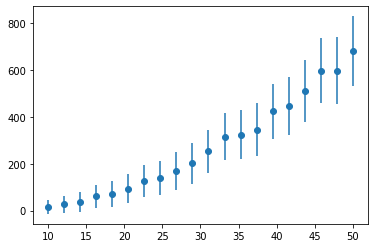

In [4]:
plt.errorbar(x, y, dy, marker='o', ls='')
plt.show()

The model for this data is a two degree polynomial, below is a function that defines this. 
The `Relationship` object is also created.

In [5]:
def two_degree(x, a, b, c):
    return c * x ** 2 + b * x + a

In [6]:
from uravu.relationship import Relationship

In [7]:
modeller = Relationship(two_degree, x, y, ordinate_error=dy)
modeller.max_likelihood('mini')

The max likelihood (which makes no consideration of the prior) is found, 

In [8]:
print(modeller.variable_medians)

[79.94767915 -8.90884397  0.46614102]


The default prior probabilities for these variables with `uravu` are uniform in the range $[x - 10x, x + 10x)$, where $x$ is the current value of the variable.

However, if you wanted the prior probability to be a normal distribution, centred on the current value of the varible with a width of 1, it would be necessary to create a custom prior function. 
This function is shown below. 

In [9]:
from scipy.stats import norm

def custom_prior():
    priors = []
    for var in modeller.variable_medians:
        priors.append(norm(loc=var, scale=1))
    return priors

Note that the function returns a list of 'frozen' `scipy` RV objects that describe the shape of the priors. 

To make use of these priors, they must be passed to the `mcmc` or `nested_sampling` functions as the `prior_function` keyword argument. 

In [10]:
modeller.mcmc(prior_function=custom_prior)

100%|██████████| 1000/1000 [01:09<00:00, 14.48it/s]


In [11]:
modeller.nested_sampling(prior_function=custom_prior)

2280it [00:36, 62.00it/s, +500 | bound: 2 | nc: 1 | ncall: 18751 | eff(%): 14.826 | loglstar:   -inf < -110.472 <    inf | logz: -114.157 +/-  0.094 | dlogz:  0.001 >  0.509]


In [12]:
print(modeller.ln_evidence)

-114.16+/-0.09


Any `scipy` [statistical function](https://docs.scipy.org/doc/scipy/reference/stats.html) that has a `logpdf` class method may be used in the definition of priors. 